In [2]:
from casadi import *
from casadi.tools import *
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg

# Keller's model

> In his original 1974 paper, Keller proposed a model to determine "how a runner should vary his speed $v(t)$ during a race of distance $D$ in order to run it in the shortest time". 

$$D = \int_0^T v(t) dt$$

> The velocity satisfies the equation of motion:

$$\frac{dv(t)}{dt} = u(t) - \frac{v(t)}{\tau}$$

> $v/\tau$ is a resistive force per unit mass, $\tau$ is a given constant, $u(t)$ ($f(t)$) is the propulsive force per unit mass, controlled by the runner. Furthermore, $\forall t \ f(t)\leq F$, where $F$ is a maximum value.  

> The force affects the quantity $E(t)$ of available oxygen in the muscles per unit mass (oxygen is consumed in reactions which release the energy used in running). Energy is used at the rate $f v$, the oxygen is supplied at a rate $\sigma$. The oxygen balance equation is:

$$\frac{d E}{d t} = \sigma - f v$$

> Eventually, Keller found $v(t)$, $f(t)$ and $E(t)$ that minimized the total running time $T$. 

> Let's use this model in our optimization problem of the rat running on a treadmill. Let's work entirely in the frame of the laboratory. 

> Taking $f$ as the control parameter, the state can be written as:

$$x = \begin{pmatrix}
x_0(t)\\
x_1(t)
\end{pmatrix}=
\begin{pmatrix}
\textrm{position}\\
\textrm{velocity}
\end{pmatrix}$$

$$\dot{x} = \begin{pmatrix}
x_1(t)\\
u - \frac{|x_1(t)-v_t|}{\tau}
\end{pmatrix}=
\begin{pmatrix}
\textrm{velocity}\\
\textrm{acceleration}
\end{pmatrix}$$

> The cost that we will minimize is:

$$E(x(t),u(t))=\int_0^T \frac{d E}{d t}=\int_0^T \left[\sigma - u|x_1(t) - v_t|\right] dt$$

> We know that $v_{max}=\tau \times F$, so the only unknown parameters are $\tau$ and $\sigma$. These can be estimated using values computed for human beings. The influence of these parameters on the optimal trajectories is discussed in the following sections.

$$0.0 \leq x_0(t) \leq L_{tread}$$
$$-0.6 \leq x_1(t) \leq 0.1$$ 

The rat should only run against the treadmill with an absolute velocity $|v_{max}|=0.7$ m/s.

$$-\frac{|v_{max}|}{\tau} \leq f(t) \leq \frac{|v_{max}|}{\tau}$$

In [6]:
## OLD INACURRATE FUNCTIONS ###

# def penalty_function(x,t,mux,mut,kxpenalty,steepnesst,vtapis):
#     '''This function generates a spatio-temporal energy barrier: spatially centered around x = 'mux', with steepness 'kxpenalty'
#     and temporally centered around t = 'mut', with steepness 'steepnesst'.'''
#     kTt = mut/steepnesst
#     max_height=.4                   # cost of running 10s at the velocity of the treadmill (max penalty)
#     amplitude = max_height/(1+np.exp((t-mut)/kTt))  # penalty maximum at t=mut...
#     kTx = mux/kxpenalty
#     return(10*amplitude/(1+np.exp((x-mux)/kTx)))       # ...and x=mux


# def reward_function(x,t,mux,mut,steepnesst):
#     '''This function generates a spatio-temporal energy valley: spatially centered around x = mux (gaussian
#     with variance sigma2), and starting temporally at t = mut with a slope determined by steepnesst'''
#     sigma1 = 3.0        #temporal variance (of associated gaussian)
#     kT = mut/steepnesst
#     amplitude = -np.exp(-(t-mut)**2/2/sigma1**2)/(1+np.exp((-(t-mut))/kT))  #asymmetric time evolution (x=0)
#     sigma2=0.01
#     return(10*amplitude*np.exp(-(x-mux)**2/2/sigma2**2))                   #spatio-temporal evolution


def heaviside(x,k,mu,amp):
    '''This function generates a Heaviside step function of steepness k, centered around mu and of amplitude amp'''
    return(amp/(1+np.exp(-2*k*(x-mu))))

def reward_function2(t,dt,reward_max,x,sigma_x,mu_x):
    '''This function generates the infinitesimal reward function with a width of the well dt, the area
    of the well equal to reward_max, centered spatially around mu_x with a Gaussian spread equal to sigma_x'''
    mu=7.0 #the reward peak is centered around this value
    coeff_rwd_decrease = (-0.38*reward_max+reward_max)/(15.0-mu) #experimental coefficient for the linear decrease of the reward
    amplitude = heaviside(x=t,k=100,mu=mu+dt,amp=reward_max/dt+coeff_rwd_decrease)+heaviside(x=t,k=100,mu=mu-dt,amp=-reward_max/dt)
    return(amplitude*np.exp(-(x-mu_x)**2/2/sigma_x**2))   

def penalty2(t,mut,kt,height,x,mux,kx):
    '''This function generates the infinitesimal penalty function, centered timewise around mut, with steepness kt
    and centered spatially around mux with steepness kx. The height of the time step can be adjusted with height.'''
    amplitude = heaviside(-t,kt,-mut,height)
    return(amplitude/(1+np.exp(2*(x-mux)*kx)))


def optimal_trajectory(tau_res,sigma,x0,xf,tf,vtapis,kxpenalty,reward_max):
    '''This function takes parameters a, b, initial position x0 and final position xf and 
    computes the OC problem assuming either a linear cost (cost='linear', Int_0^T a+b*v dt), 
    or a quadratic one (cost='quadratic',Int_0^T a+b*v*v dt). It returns respectively the 
    optimal trajectory, the associated time array, the optimal 
    velocity and its associated time array.'''
    Ltread=0.9
    nk = 1000
    mu=0.1    # Control discretization
    kT=mu/1
    
    
    # Declare variables
    t  = SX.sym("t")    # time
    u  = SX.sym("u")    # control

    states = struct_symSX([
            entry('x',shape=2),    #  states
            entry('L')             #  helper state: Langrange integrand
         ])

    # Create a structure for the right hand side
    rhs = struct_SX(states)
    x = states['x']
    rhs["x"] = vertcat(x[1], u - fabs(x[1]-vtapis)/tau_res)
    rhs["L"] = sigma - u*fabs(x[1]-vtapis)+penalty2(t=t,mut=7.0,kt=100,height=1.0,x=x[0],mux=0.1,kx=kxpenalty)+reward_function2(t=t,dt=0.1,reward_max=reward_max,x=x[0],sigma_x=0.1,mu_x=0.1)#+penalty_function(x=x[0],t=t,mux=0.1,mut=3.5,kxpenalty=kxpenalty,steepnesst=5,vtapis=vtapis)+reward_function(x=x[0],t=t,mux=0.1,mut=6.95,steepnesst=1000)
    
    # ODE right hand side function
    f = Function('f', [t,states,u],[rhs])

    # Objective function (meyer term)
    m = Function('m', [t,states,u],[states["L"]])

    # Control bounds
    u_min = -0.7/tau_res
    u_max = -u_min  #same muscular force in acceleration and deceleration...
    u_init = 0.0

    u_lb = np.array([u_min])
    u_ub = np.array([u_max])
    u_init = np.array([u_init])

    # State bounds and initial guess
    x_min =  [0.0,   vtapis-0.7, -inf]
    x_max =  [Ltread,vtapis,  inf]
    xi_min = [x0,  vtapis-0.7,  0.0]
    xi_max = [x0,  vtapis,  0.0]
    xf_min = [xf,  vtapis-0.7, -inf]
    xf_max = [xf,  vtapis,  inf]
    x_init = [ 0.0,  0.0,  0.0]

    # Dimensions
    nx = 3
    nu = 1

    # Choose collocation points
    tau_root = [0] + collocation_points(3,"radau")

    # Degree of interpolating polynomial
    d = len(tau_root)-1

    # Size of the finite elements
    h = tf/nk

    # Coefficients of the collocation equation
    C = np.zeros((d+1,d+1))

    # Coefficients of the continuity equation
    D = np.zeros(d+1)

    # Dimensionless time inside one control interval
    tau = SX.sym("tau")

    # All collocation time points
    T = np.zeros((nk,d+1))
    for k in range(nk):
        for j in range(d+1):
            T[k,j] = h*(k + tau_root[j])

    # For all collocation points
    for j in range(d+1):
    # Construct Lagrange polynomials to get the polynomial basis at the collocation point
        L = 1
        for r in range(d+1):
            if r != j:
                L *= (tau-tau_root[r])/(tau_root[j]-tau_root[r])

        # Evaluate the polynomial at the final time to get the coefficients of the continuity equation
        lfcn = Function('lfcn', [tau],[L])
        D[j] = lfcn(1.0)

        # Evaluate the time derivative of the polynomial at all collocation points to get the coefficients of the continuity equation
        tfcn = Function('tfcn', [tau],[tangent(L,tau)])
        for r in range(d+1):
            C[j,r] = tfcn(tau_root[r])

    # Structure holding NLP variables
    V = struct_symMX([
      (
       entry("X",repeat=[nk+1,d+1],struct=states),
       entry("U",repeat=[nk],shape=nu)
      )
    ])

    vars_lb   = V()
    vars_ub   = V()
    vars_init = V()

    # Set states and its bounds
    vars_init["X",:,:] = repeated(repeated(x_init))
    vars_lb["X",:,:]   = repeated(repeated(x_min))
    vars_ub["X",:,:]   = repeated(repeated(x_max))

    # Set controls and its bounds
    vars_init["U",:] = repeated(u_init)
    vars_lb["U",:]   = repeated(u_min)
    vars_ub["U",:]   = repeated(u_max)

    # State at initial time
    vars_lb["X",0,0] = xi_min
    vars_ub["X",0,0] = xi_max

    # State at end time
    vars_lb["X",-1,0] = xf_min
    vars_ub["X",-1,0] = xf_max

    # Constraint function for the NLP
    g = []
    lbg = []
    ubg = []

    # For all finite elements
    for k in range(nk):

        # For all collocation points
        for j in range(1,d+1):

        # Get an expression for the state derivative at the collocation point
            xp_jk = 0
            for r in range (d+1):
                xp_jk += C[r,j]*V["X",k,r]

            # Add collocation equations to the NLP
            fk = f(T[k][j], V["X",k,j], V["U",k])
            g.append(h*fk - xp_jk)
            lbg.append(np.zeros(nx)) # equality constraints
            ubg.append(np.zeros(nx)) # equality constraints

        # Get an expression for the state at the end of the finite element
        xf_k = 0
        for r in range(d+1):
            xf_k += D[r]*V["X",k,r]

        # Add continuity equation to NLP
        g.append(V["X",k+1,0] - xf_k)
        lbg.append(np.zeros(nx))
        ubg.append(np.zeros(nx))

    # Concatenate constraints
    g = vertcat(*g)

    # Objective function
    f = m(T[nk-1][d],V["X",nk,0],V["U",nk-1])

    # NLP
    nlp = {'x':V, 'f':f, 'g':g}

    ## ----
    ## SOLVE THE NLP
    ## ----

    # Set options
    opts = {}
    opts["expand"] = True
    #opts["ipopt.max_iter"] = 4

    # Allocate an NLP solver
    solver = nlpsol("solver", "ipopt", nlp, opts)
    arg = {}

    # Initial condition
    arg["x0"] = vars_init

    # Bounds on x
    arg["lbx"] = vars_lb
    arg["ubx"] = vars_ub

    # Bounds on g
    arg["lbg"] = np.concatenate(lbg)
    arg["ubg"] = np.concatenate(ubg)

    # Solve the problem
    res = solver(**arg)

    # Print the optimal cost
    print("optimal cost: ", float(res["f"]))

    # Retrieve the solution
    opt = V(res["x"])

    # Get values at the beginning of each finite element
    x0_opt = opt["X",:,0,"x",0]
    x1_opt = opt["X",:,0,"x",1]
    x2_opt = opt["X",:,0,"L"]

    u_opt = opt["U",:,0]

    tgrid = np.linspace(0,tf,nk+1)
    tgrid_u = np.linspace(0,tf,nk)
    
    return(x0_opt,x1_opt,tgrid,u_opt,tgrid_u)


In [11]:
# PARAMETERS FOR THE COMPUTATION
vtapis = 0.1
kxpenalty=100  # steepness of penalty cost (the higher the steeper: 100 very steep, 3 slightly, 1 very diffused)
x0 = 0.0     # initial position
xf = 0.1     # final position 
tf = 15.     # final time (duration of experiment)
reward_max = 10.0
sigma = 1.708
tau = 0.1
xk,xdotk,tk,acck,tak = optimal_trajectory(tau_res=tau,sigma=sigma,x0=x0,xf=xf,tf=tf,vtapis=vtapis,kxpenalty=kxpenalty,reward_max=reward_max)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    56993
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     9000

Total number of variables............................:    13009
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     9006
                     variables with only upper bounds:        0
Total number of equality constraints.................:    12000
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -1.1941236e+000 5.71e-003 1.23e-002  -5.7 1.27e+001  -3.8 1.22e-001 1.93e-001f  1
  81 -1.2117579e+000 5.41e-003 1.16e-002  -5.7 5.18e+001  -4.2 4.96e-002 5.20e-002f  1
  82 -1.2710746e+000 1.23e-002 6.89e-002  -5.7 3.33e+001  -4.7 4.03e-002 2.16e-001h  1
  83 -1.2770218e+000 1.20e-002 3.36e-002  -5.7 1.59e+001  -5.2 8.75e-002 2.98e-002f  1
  84 -1.2793397e+000 1.18e-002 3.32e-002  -5.7 2.69e+001  -5.7 3.54e-002 1.12e-002h  1
  85 -1.3186146e+000 1.20e-002 4.19e-002  -5.7 5.48e+001  -6.1 2.04e-003 1.40e-001f  1
  86 -1.3210076e+000 1.18e-002 6.72e-002  -5.7 4.82e+000  -6.6 5.84e-001 1.93e-002h  1
  87 -1.3400810e+000 1.05e-002 5.15e-002  -5.7 4.57e+001  -7.1 9.03e-003 1.12e-001f  1
  88 -1.3405333e+000 1.04e-002 1.02e-001  -5.7 4.16e+000  -7.6 6.55e-001 4.29e-003h  1
  89 -1.3598031e+000 7.98e-003 7.49e-002  -5.7 9.82e-001  -8.1 1.02e-001 2.34e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

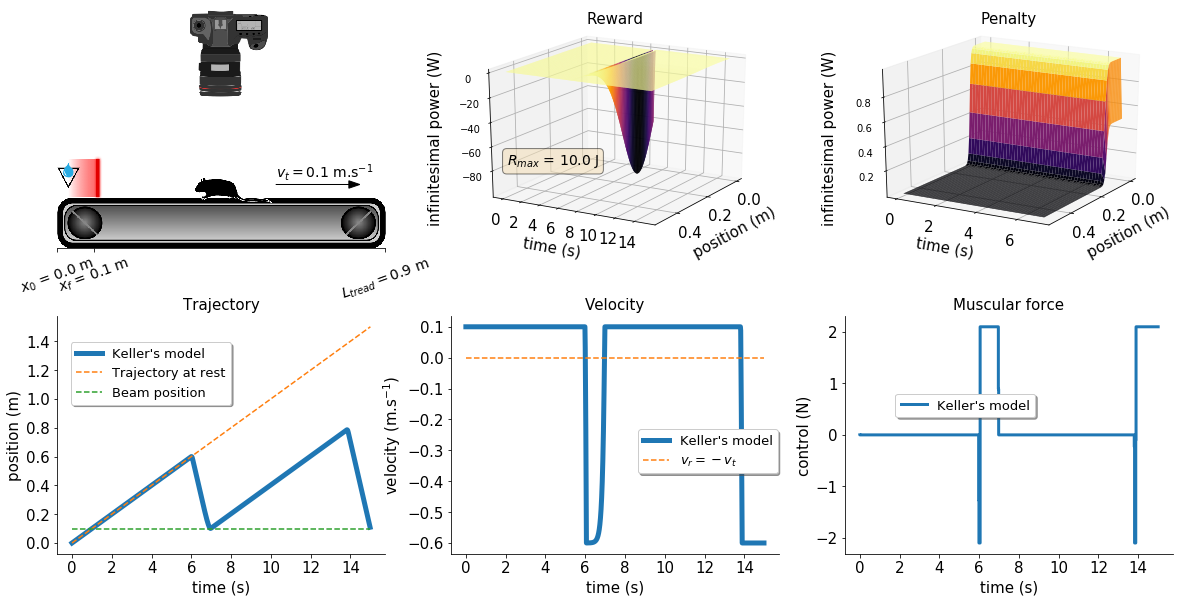

In [12]:
#PLOTING THE RESULTS

limit=1000 #hide the last part of the plots for report

#GENERATE FIGURE
fig3 = plt.figure(figsize=(20,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=2)
gs = fig3.add_gridspec(6, 6)

# SCHEME OF THE TASK
f3_ax1 = fig3.add_subplot(gs[:3, :2])
img1 = mpimg.imread('experimental_setup.png')
f3_ax1.imshow(img1,aspect='auto')
f3_ax1.spines['top'].set_visible(False)
f3_ax1.spines['right'].set_visible(False) 
f3_ax1.spines['left'].set_visible(False) 
f3_ax1.set_yticks([])
f3_ax1.set_xticks([x0*1000,xf*1000,900])
plt.xticks(rotation=20)
f3_ax1.set_xticklabels([r'$x_0$ = '+str(x0)+' m',r'$x_f$ = '+str(xf)+' m',r'$L_{tread} = 0.9$ m'],size=14)
plt.arrow(600,470,200,0,head_width=20.0,color='black')
plt.text(600,450,r'$v_t = $'+str(vtapis)+' m.s$^{-1}$',size=14)


#REWARD FUNCTION
f3_ax2 = fig3.add_subplot(gs[:3, 2:4],projection="3d")
f3_ax2.set_title('Reward',size=15)
t = np.linspace(0,15,100)
x = np.linspace(0.0,0.50,100)
X,T = np.meshgrid(x,t)
Z = reward_function2(t=T,dt=0.1,reward_max=reward_max,x=X,sigma_x=0.1,mu_x=0.1)
f3_ax2.plot_surface(X, T, Z, rstride=1, cstride=1,cmap='inferno', edgecolor='none')
plt.xlabel('position (m)',size=15,labelpad=10)
plt.xticks(np.arange(0, 0.5, step=0.2))
plt.ylabel('time (s)',size=15,labelpad=10)
f3_ax2.zaxis.set_rotate_label(False) 
f3_ax2.set_zlabel('infinitesimal power (W)',size=15,labelpad=10,rotation=90)
#f3_ax2.set_zticks(np.linspace(0,-10.0,5))
f3_ax2.view_init(20, 30)
plt.xticks(size = 15)
plt.yticks(size = 15)
f3_ax2.text2D(0.17, 0.35, r"$R_{max}$ = "+str(reward_max)+' J', transform=f3_ax2.transAxes,size=14,bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

#PENALTY FUNCTION
f3_ax3 = fig3.add_subplot(gs[:3, 4:],projection='3d')
f3_ax3.set_title('Penalty',size=15)
x = np.linspace(0.0,0.5,100)
t = np.linspace(0.0,7.0)
X,T = np.meshgrid(x,t)
Z = penalty2(t=T,mut=7.0,kt=100,height=1.0,x=X,mux=0.1,kx=kxpenalty)
f3_ax3.plot_surface(X, T, Z, rstride=1, cstride=1,cmap='inferno', edgecolor='none')
plt.xlabel('position (m)',size=15,labelpad=10)
plt.xticks(np.arange(0, 0.5, step=0.2))
plt.yticks(np.arange(0, 7, step=2))
plt.ylabel('time (s)',size=15,labelpad=10)
f3_ax3.zaxis.set_rotate_label(False) 
f3_ax3.set_zlabel('infinitesimal power (W)',size=15,labelpad=10,rotation=90)
#f3_ax3.set_zticks(np.linspace(0,4,5))
f3_ax3.view_init(20, 30)
plt.xticks(size = 15)
plt.yticks(size = 15)


#TRAJECTORY
f3_ax4 = fig3.add_subplot(gs[3:,:2])
f3_ax4.set_title('Trajectory',size=15)
plt.plot(tk[:limit],xk[:limit],label="Keller's model",linewidth=5.0,alpha=1.0)
plt.plot(tk,[0.1*t for t in tk],'--',label='Trajectory at rest')
plt.plot(tk,[0.1 for t in tk],'--',label='Beam position')
f3_ax4.spines['top'].set_visible(False)
f3_ax4.spines['right'].set_visible(False) 
f3_ax4.legend(fontsize=13,bbox_to_anchor=(.55, .6),shadow=True, ncol=1)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.ylabel('position (m)',size=15)
plt.xlabel('time (s)',size=15)


#VELOCITY
f3_ax5 = fig3.add_subplot(gs[3:, 2:4])
f3_ax5.set_title('Velocity',size=15)
plt.plot(tk[:limit],xdotk[:limit],label="Keller's model",linewidth=5.0)
plt.plot(tk,[0.0 for t in tk],'--',label=r'$v_r=-v_t$')
plt.ylabel(r'velocity (m.s$^{-1}$)',size=15)
plt.xlabel('time (s)',size = 15)
f3_ax5.spines['top'].set_visible(False)
f3_ax5.spines['right'].set_visible(False) 
f3_ax5.legend(fontsize=13,bbox_to_anchor=(.55, .55),shadow=True, ncol=1)
plt.xticks(size = 15)
plt.yticks(size = 15)


#Muscular force
f3_ax6 = fig3.add_subplot(gs[3:, 4:])
f3_ax6.set_title('Muscular force',size=15)
plt.step(tak[:limit],[0.3*f for f in acck][:limit],label="Keller's model",linewidth=3.0)
plt.ylabel(r'control (N)',size=15)
plt.xlabel('time (s)',size=15)
f3_ax6.spines['top'].set_visible(False)
f3_ax6.spines['right'].set_visible(False) 
f3_ax6.legend(fontsize=13,bbox_to_anchor=(.6, .7),shadow=True, ncol=1)
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.savefig('Results_tau'+str(tau)+'sigma_'+str(sigma)+'.pdf')
plt.show()

# Testing $\tau$'s influence

The following can be time consuming, depending on the number of points in the array $\tau$. Only run if you need the plot.

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    56993
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     9000

Total number of variables............................:    13009
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     9006
                     variables with only upper bounds:        0
Total number of equality constraints.................:    12000
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

  83 -1.2765624e+001 8.42e-003 5.66e-002  -5.7 5.64e+001  -6.1 3.76e-002 2.01e-002h  1
  84 -1.2770891e+001 9.88e-003 7.94e-002  -5.7 3.52e+001  -6.6 1.15e-002 1.74e-001f  1
  85 -1.2771819e+001 9.77e-003 7.86e-002  -5.7 6.69e+001  -4.3 3.86e-003 1.05e-002h  1
  86 -1.2778312e+001 8.76e-003 1.17e-001  -5.7 1.64e+001  -4.8 2.91e-002 3.84e-001f  1
  87 -1.2777334e+001 8.25e-003 1.17e-001  -5.7 1.80e+001  -5.3 4.63e-005 7.46e-002h  1
  88 -1.2778510e+001 8.17e-003 1.11e-001  -5.7 5.00e+001  -5.8 2.01e-002 2.68e-002f  1
  89 -1.2772580e+001 4.75e-003 1.32e+002  -5.7 7.81e+000  -6.3 6.76e-007 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -1.2775641e+001 5.57e-003 1.27e+002  -5.7 8.88e+001  -6.7 7.00e-002 4.08e-002h  1
  91 -1.2779324e+001 6.52e-003 1.17e+002  -5.7 5.55e+001  -7.2 6.55e-002 7.56e-002f  1
  92 -1.2780053e+001 6.17e-003 1.09e+002  -5.7 1.74e+001  -4.1 6.91e-006 5.35e-002f  1
  93 -1.2778278e+001 3.45e-003 6.06e+001  -5.7 3.

  33 -5.7942374e+000 2.44e-003 4.30e-003  -3.8 1.15e+001  -3.9 5.52e-001 2.73e-001h  1
  34 -5.8436686e+000 7.38e-004 1.72e-003  -3.8 3.07e+000  -3.5 1.00e+000 8.94e-001f  1
  35 -5.8542623e+000 9.17e-004 5.35e-003  -3.8 9.02e+000  -4.0 5.88e-001 1.83e-001f  1
  36 -5.8728993e+000 5.21e-004 7.31e-004  -3.8 2.53e+000  -3.5 1.00e+000 1.00e+000f  1
  37 -5.9242522e+000 1.35e-003 3.83e-002  -5.7 2.50e+001  -4.0 1.39e-001 1.01e-001f  1
  38 -6.0255260e+000 1.53e-003 8.54e-002  -5.7 8.48e+000  -3.6 1.52e-001 2.82e-001f  1
  39 -6.0741472e+000 4.29e-003 8.16e-002  -5.7 4.97e+001  -4.1 9.47e-002 1.01e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -6.0847867e+000 4.13e-003 3.43e-002  -5.7 1.12e+001  -3.6 1.08e-001 4.13e-002h  1
  41 -6.1008764e+000 4.47e-003 1.97e-002  -5.7 8.33e+001  -4.1 5.16e-002 2.87e-002h  1
  42 -6.1846114e+000 4.77e-003 1.08e-001  -5.7 1.44e+001  -3.7 1.39e-001 3.09e-001h  1
  43 -6.1982107e+000 4.69e-003 1.01e-001  -5.7 1.

  21 -1.1525785e+000 6.42e-004 5.22e-003  -5.7 1.81e+001  -8.1 6.99e-002 6.87e-002h  1
  22 -1.1747290e+000 6.19e-004 8.58e-004  -5.7 2.01e+001  -8.6 6.16e-002 6.86e-002h  1
  23 -1.1926510e+000 5.85e-004 4.61e-003  -5.7 1.96e+001  -9.1 6.63e-002 5.92e-002h  1
  24 -1.2093646e+000 5.52e-004 1.82e-003  -5.7 1.91e+001  -9.6 5.31e-002 5.66e-002h  1
  25 -1.2258811e+000 5.19e-004 2.82e-003  -5.7 2.03e+001 -10.0 5.27e-002 5.94e-002h  1
  26 -1.2415711e+000 4.89e-004 7.43e-003  -5.7 2.09e+001 -10.5 5.22e-002 5.97e-002h  1
  27 -1.2559984e+000 4.60e-004 1.08e-002  -5.7 2.07e+001 -11.0 5.17e-002 5.80e-002h  1
  28 -1.2688519e+000 4.35e-004 1.14e-002  -5.7 1.91e+001 -11.5 5.20e-002 5.41e-002h  1
  29 -1.2801616e+000 4.14e-004 7.96e-003  -5.7 1.59e+001 -11.9 5.43e-002 4.90e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -1.2903370e+000 3.96e-004 8.25e-004  -5.7 2.51e+001 -12.4 5.99e-002 4.40e-002h  1
  31 -1.2998725e+000 3.80e-004 1.45e-002  -5.7 3.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -8.5117265e-001 2.75e-004 1.65e-001  -5.7 1.50e+001  -6.7 5.54e-002 3.51e-002h  1
  21 -8.5456692e-001 2.66e-004 1.56e-001  -5.7 1.68e+001  -7.2 4.90e-002 3.26e-002h  1
  22 -8.5804689e-001 2.56e-004 1.49e-001  -5.7 1.76e+001  -7.7 4.32e-002 3.50e-002h  1
  23 -8.6244424e-001 2.44e-004 1.42e-001  -5.7 1.49e+001  -8.2 4.44e-002 4.76e-002h  1
  24 -8.6795907e-001 2.28e-004 1.36e-001  -5.7 1.19e+001  -8.7 5.04e-002 6.50e-002h  1
  25 -8.7365348e-001 2.12e-004 1.29e-001  -5.7 1.09e+001  -9.1 5.35e-002 7.27e-002h  1
  26 -8.7914919e-001 1.96e-004 1.23e-001  -5.7 1.05e+001  -9.6 5.46e-002 7.58e-002h  1
  27 -8.8447016e-001 1.80e-004 1.17e-001  -5.7 1.02e+001 -10.1 5.54e-002 7.93e-002h  1
  28 -8.8960437e-001 1.65e-004 1.11e-001  -5.7 9.76e+000 -10.6 5.64e-002 8.29e-002h  1
  29 -8.9075848e-001 1.62e-004 1.04e-001  -5.7 9.05e+000 -11.0 5.89e-002 2.00e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

  18 2.6638827e-001 8.55e-007 3.83e-003  -5.7 4.02e-002 -12.1 6.88e-001 1.00e+000f  1
  19 2.6617658e-001 5.47e-007 1.12e-006  -5.7 2.28e-002 -12.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 2.6433382e-001 5.14e-006 3.85e-003  -8.6 4.30e-002 -13.1 4.53e-001 7.76e-001h  1
  21 2.6366534e-001 4.29e-006 2.60e-003  -8.6 5.21e-002 -13.5 4.86e-001 7.21e-001h  1
  22 2.6345250e-001 1.91e-006 1.10e-003  -8.6 5.59e-002 -14.0 6.06e-001 7.08e-001h  1
  23 2.6338163e-001 9.84e-007 5.08e-004  -8.6 6.30e-002 -14.5 5.70e-001 7.33e-001h  1
  24 2.6336100e-001 4.84e-007 2.11e-004  -8.6 6.53e-002 -15.0 6.03e-001 7.67e-001h  1
  25 2.6335496e-001 2.09e-007 8.25e-005  -8.6 5.07e-002 -15.5 6.29e-001 9.41e-001f  1
  26 2.6335456e-001 1.25e-007 1.85e-005  -8.6 1.46e-002 -15.9 7.78e-001 1.00e+000f  1
  27 2.6335455e-001 5.99e-010 4.30e-013  -8.6 2.59e-003 -16.4 1.00e+000 1.00e+000h  1

Number of Iterations....: 27

                            

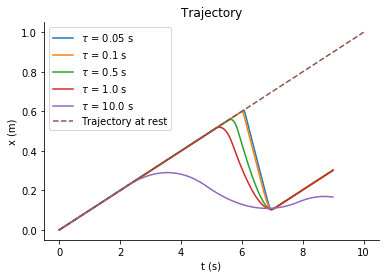

In [19]:
def acceleration(v,tf):
    acc = []
    dt = tf/len(v)
    for i in range(1,len(v)):
        acc.append((v[i]-v[i-1])/dt)
    return(acc)

# PARAMETERS FOR THE COMPUTATION
vtapis = 0.1
kxpenalty=100  # steepness of penalty cost (the higher the steeper: 100 very steep, 3 slightly, 1 very diffused)
x0 = 0.0     # initial position
xf = 0.1     # final position 
tf = 10.     # final time (duration of experiment)
sigma = 1.708
reward_max=10.0

tau_acc = []
tau = [0.05,0.1,0.5,1.0,10.0]
limit=900  #hide last part of plots

#Define figure of trajectories for different values of tau
fig = plt.figure()
ax = fig.add_subplot(111)
for toto in tau:
    xk,xdotk,tk,acck,tak = optimal_trajectory(tau_res=toto,sigma=sigma,x0=x0,xf=xf,tf=tf,vtapis=vtapis,kxpenalty=kxpenalty,reward_max=reward_max)
    acceleration_profile=acceleration(np.asarray(xdotk),tf) #computes the acceleration from a velocity profile
    max_acc = np.min(acceleration_profile) #finds the minimum of the acceleration (negative)
    tau_acc.append(max_acc) 
    ax.plot(tk[:limit],xk[:limit],label=r'$\tau$ = '+str(toto)+' s')
    #ax.plot(tak[:limit],acck[:limit],label=r'$\tau$ = '+str(toto)+' s')

ax.plot(tk,[0.1*t for t in tk],'--',label='Trajectory at rest')
plt.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False) 
plt.ylabel('x (m)')
plt.xlabel('t (s)')
plt.title('Trajectory')
plt.savefig('tau_keller2.pdf')

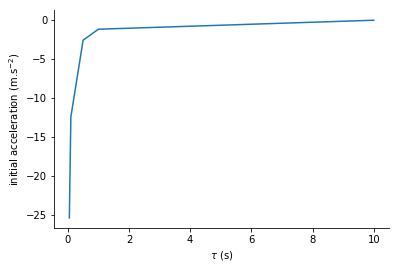

In [20]:
#Plot tau against the associated max acceleration

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.plot(tau,tau_acc)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False) 
plt.xlabel(r'$\tau$ (s)')
plt.ylabel('initial acceleration (m.s$^{-2})$')

plt.savefig('tau_keller_acc2.pdf')